# Peeling back the fastai layered AI with Fashion MNIST

Tags: python, data, fastai

date: 2022-05-23T19:05:13+10:00

feature_image: /images/fashion_mnist_training_loop.jpg
  
<!--eofm-->

[Chapter 4 of the fastai book](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) covers how to build a Neural Network for distinguishing 3s and 7s on MNIST from scratch. 
We're going to do a similar thing but instead of building the neural network from the ground up we're going to use fastai's *layered API* to build it top down.
We'll start with the high level API to train a dense neural network in a few lines.
Then we'll redo the problem going deeper and deeper into the API.
At the very core it's mainly PyTorch, and we'll have a pure PyTorch implementation like in the book.
Then we'll start rebuilding the abstractions from scratch to get a high level API like we started with.

Instead of using the MNIST digits we'll use [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), which contains little black and white images of different types of clothing.
This is a bit harder and a convolutional neural network would perform better here (as demonstrated in [v3 of fastai course](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-resnet-mnist.ipynb)).
But to keep things simple we'll use a dense neural network.

This post was generated with a Jupyter notebook. You can also [view this notebook on Kaggle](https://www.kaggle.com/code/edwardjross/fashion-mnist-with-prototype-methods/notebook) or [download the Jupyter notebook](/notebooks/fashion-mnist-with-prototype-methods.ipynb).

# Training a model in 5 lines of code

We train a model to recognise these items of clothing from scratch in just 6 lines using fastai's high level API.
It should take a minute or two to run on a CPU (for such a small model and data there is marginal benefit running on a GPU).

In [1]:
# 1. Import
from fastai.tabular.all import *
# 2. Data
df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv', dtype={'label':'category'})
# 3. Dataloader
dls = TabularDataLoaders.from_df(df, y_names='label', bs=4096, procs=[Normalize])
# 4. Learner
learn = tabular_learner(dls, layers=[100], opt_func=SGD, metrics=accuracy, config=dict(use_bn=False, bn_cont=False))
# 5. Fit
learn.fit(40, lr=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.204540,0.779914,0.735917,00:01
1,0.917599,0.632047,0.772750,00:01
2,0.787847,0.568341,0.791167,00:01
3,0.702365,0.522808,0.811083,00:01
4,0.642320,0.510324,0.811167,00:01
5,0.603035,0.491477,0.822083,00:01
6,0.568987,0.463034,0.831250,00:01
7,0.538885,0.449788,0.835583,00:01
8,0.514483,0.440531,0.839333,00:01
9,0.495511,0.436088,0.840583,00:01


We can then test the perormance on the test set; note that it's very close to the accuracy from the last line of the training above.

> 

In [2]:
df_test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv', dtype={'label': df.label.dtype})

probs, actuals = learn.get_preds(dl=dls.test_dl(df_test))

print(f'Accuracy on test set {float(accuracy(probs, actuals)): 0.2%}')

Accuracy on test set  85.88%


Looking at the [sklearn benchmarks](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#) on this dataset it's outperformed by some other models such as Support Vector Machines (SV) with 89.7% accuracy, and Gradient Boosted Trees with 88.8% accuracy.
In fact our model is almost the same as the MLPClassifier (87.7%).
See if you can beat this baseline by changing the layers, learning rate, and number of epochs.

The [*best* results](https://github.com/zalandoresearch/fashion-mnist#benchmark) on this dataset, around 92-96%, come from Convolutional Neural Networks (CNN).
The kind of approach we use here can be extended to a CNN; the other kinds of models are quite different.

## What did we just do?

Let's go back through those 5 lines slowly to see what was going on.

### 1. Import

The first line imports all the libraries we need for tabular analysis.

This includes specific fastai libraries, as well as general utilities such as Pandas, numpy and PyTorch, and much more

In [3]:
from fastai.tabular.all import *

If you want to see exactly what was imported you can look into the module or the [source code](https://github.com/fastai/fastai/blob/master/fastai/tabular/all.py).

In [4]:
import fastai.tabular.all
L(dir(fastai.tabular.all))

(#846) ['APScoreBinary','APScoreMulti','AccumMetric','ActivationStats','Adam','AdaptiveAvgPool','AdaptiveConcatPool1d','AdaptiveConcatPool2d','ArrayBase','ArrayImage'...]

This includes standard imports like "pandas as pd"

In [5]:
fastai.tabular.all.pd

<module 'pandas' from '/opt/conda/lib/python3.7/site-packages/pandas/__init__.py'>

### 2. Data

We read in the data from Pandas as a CSV, letting Pandas know that the `label` column is categorical.

In [6]:
df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv', dtype={'label':'category'})

The dataframe contains a `label` column giving the kind of image, and then 784 columns for the pixel value from 0-255.

In [7]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


A histogram of the pixels shows they are mostly 0, with values up to 255.

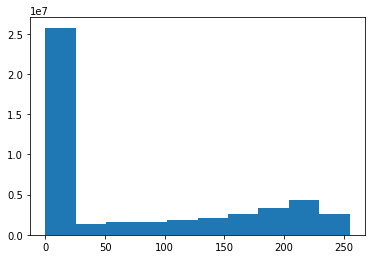

In [8]:
_ = plt.hist(df.filter(like='pixel', axis=1).to_numpy().reshape(-1))

From a singe row of the dataframe we can read the label, and the pixels

In [9]:
label, *pixels = df.iloc[0]

label, len(pixels)

('2', 784)

The 784 pixels are actually 28 rows of the image, each containing 28 columns.
If we rearrange them we can plot it as an image.

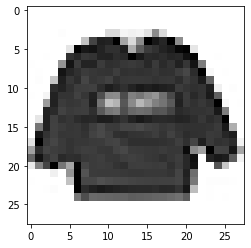

In [10]:
image_array = np.array(pixels).reshape(28, 28)
_ = plt.imshow(image_array, cmap='Greys')

All we are seeing here are the pixel intensities from 0 (white) to 255 (black) on a grid.

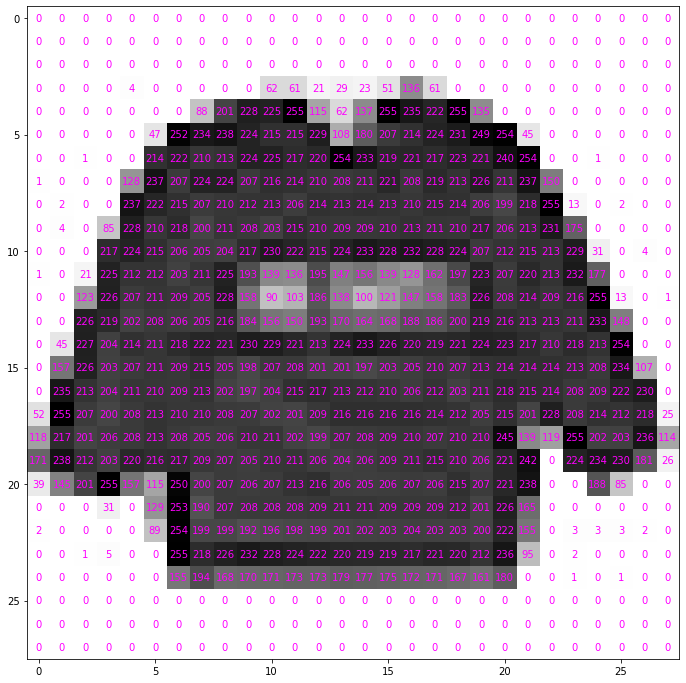

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(image_array, cmap="Greys")

for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
        text = ax.text(j, i, image_array[i, j], ha="center", va="center", color="magenta")

The labels are categorical codes for different types of clothing.



We can copy the label description and convert it into a Python dictionary.

In [12]:
labels_txt = """
Label	Description
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
""".strip()

labels = dict([row.split('\t') for row in labels_txt.split('\n')[1:]])
labels

{'0': 'T-shirt/top',
 '1': 'Trouser',
 '2': 'Pullover',
 '3': 'Dress',
 '4': 'Coat',
 '5': 'Sandal',
 '6': 'Shirt',
 '7': 'Sneaker',
 '8': 'Bag',
 '9': 'Ankle boot'}

The image above is of a Pullover

In [13]:
label, labels[label]

('2', 'Pullover')

We've got 6000 images of each type.

In [14]:
df.label.map(labels).value_counts()

T-shirt/top    6000
Trouser        6000
Pullover       6000
Dress          6000
Coat           6000
Sandal         6000
Shirt          6000
Sneaker        6000
Bag            6000
Ankle boot     6000
Name: label, dtype: int64

### 3. Dataloader

Now we have our raw data we need a way to pass that into the model in a way it understands.
We do this with a *DataLoader* reading from the dataframe.
We need to tell it:

* df: the dataframe to read from
* y_names: the name of the column containing the outcome variable, here `label`
* bs: the batch size, how many rows to feed to the model each time. We use 4096 because the data and models are small
* procs: any preprocessing steps to do, here we use `Normalize` to map them from 0-255 to a more reasonable range.
* cont_names: The name of the continuous columns

Note that before we didn't pass `cont_names` and it automatically detected them; however it can reorder the columns so we specify it here for clarity.

In [15]:
dls = TabularDataLoaders.from_df(df, y_names='label', bs=4096, procs=[Normalize], cont_names=list(df.columns[1:]))

This data loader can then produce the pixel arrays for a subset of rows, and the outcome labels on demand.
Note these are the values *before* using procs.

In [16]:
dls.show_batch()

Behind the scenes this also splits our data into a *training* dataset that we use to update the model parameters, and a *validation* dataset that we use to evaluate the model.
This is really important because neural networks are incredibly flexible and can often memorise the training data; the validation dataset is an exam with questions the model has never seen before.

We can access the individual dataloaders with `.train` and `.valid` respectively.

In [17]:
dls.train, dls.valid

(<fastai.tabular.core.TabDataLoader at 0x7f4c0e502d10>,
 <fastai.tabular.core.TabDataLoader at 0x7f4c0e502e90>)

These can be iterated on to get batches of examples to train or evaluate the model on.

This particular dataloader returns a tuple containing 3 items

In [18]:
batch = next(iter(dls.train))
type(batch), len(batch)

(tuple, 3)

The first is an empty array.
This would contain any categorical variables in our model, but since we are only using the continuous pixel values it's empty.

In [19]:
batch[0]

tensor([], size=(4096, 0), dtype=torch.int64)

The second is a 4096x784 array of numbers.
These correspond to 4096 of the rows from the initial training data.

In [20]:
print(batch[1].shape)
batch[1]

torch.Size([4096, 784])


tensor([[-0.0104, -0.0225, -0.0271,  ..., -0.1582, -0.0908, -0.0321],
        [-0.0104, -0.0225, -0.0271,  ..., -0.1582, -0.0908, -0.0321],
        [-0.0104, -0.0225, -0.0271,  ..., -0.1582, -0.0908, -0.0321],
        ...,
        [-0.0104, -0.0225, -0.0271,  ...,  3.5075,  8.2715, -0.0321],
        [-0.0104, -0.0225, -0.0271,  ..., -0.1582, -0.0908, -0.0321],
        [-0.0104, -0.0225, -0.0271,  ..., -0.1582, -0.0908, -0.0321]])

We can see the image has been slightly whitened by the normalization.
This is because we normalized each pixel column *independently*; we may get better results if the normalize them all together.
But you can still tell it's some kind of top.

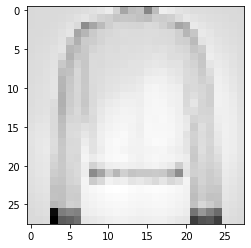

In [21]:
plt.imshow(batch[1][0].reshape(28, 28), cmap='Greys')

The final part of the batch is the *labels* from 0-9 corresponding to the each row; what we are trying to predict.

In [22]:
print(batch[2].shape)
batch[2]

torch.Size([4096, 1])


tensor([[2],
        [9],
        [5],
        ...,
        [7],
        [1],
        [9]], dtype=torch.int8)

Apparently the image above is a shirt (and not a pullover or t-shirt/top).

In [23]:
labels[str(batch[2][0][0].item())]

'Pullover'

We can iterate through the batches to see we have about 4500 labels from each category in the training dataloader

In [24]:
from collections import Counter

train_label_count = Counter()
for batch in dls.train:
    train_label_count.update(batch[2].squeeze().numpy())
    
train_label_count

Counter({1: 4507,
         9: 4567,
         3: 4449,
         7: 4554,
         6: 4517,
         0: 4447,
         4: 4486,
         5: 4540,
         2: 4496,
         8: 4493})

Similarly the validation data contains around 1200 rows each.

In [25]:
valid_label_count = Counter()
for batch in dls.valid:
    valid_label_count.update(batch[2].squeeze().numpy())
    
valid_label_count

Counter({9: 1137,
         5: 1171,
         0: 1271,
         4: 1205,
         3: 1231,
         1: 1213,
         7: 1157,
         2: 1217,
         8: 1210,
         6: 1188})

20% of the data has gone into the validation set, but only a little over 75% is in the validation set, we've dropped around 5% of the data.

In [26]:
n_valid = sum(valid_label_count.values())
n_train = sum(train_label_count.values())

{'n_train': n_train,
 'pct_train': '{:.2%}'.format(n_train / len(df)),
 'n_valid': n_valid,
 'pct_valid': '{:.2%}'.format(n_valid / len(df))}

{'n_train': 45056,
 'pct_train': '75.09%',
 'n_valid': 12000,
 'pct_valid': '20.00%'}

The reason for this is fastai has made all the batches equal length by dropping the extra examples.

In [27]:
n_train / 4096

11.0

### 5. Learner

Now we have our dataloaders to load the data for training and validation we need a way to learn from the data.
The fastai learner contains all the things we need to do that:

1. the dataloaders
2. a *model* consisting of an *architecture* and *parameters*, which can make *output predictions* from *inputs*
3. any *metrics* for quantitatively evaluating the system
4. a *loss function* for automatically evaluating the quality of *output predictions* against *labels*
5. an *optimiser* for updating the parameters to minimise the loss function

We do all this with a [tabular_learner](https://docs.fast.ai/tabular.learner.html#tabular_learnerhttps://docs.fast.ai/tabular.learner.html#tabular_learner), we specify:

* dls: the dataloaders
* layers: The *hidden* layers that define the *architecutre* of the model, we use a single layer of dimension 100
* opt_fun: The optimiser to use for updating parameters, here Stochastic Gradient Descent
* metrics: human interpretable metrics; accuracy is the proportion of labels the model correctly guesses
* config: model configuration; here we are turning off BatchNorm which is a technique to help train Deep Neural Networks. As we're trying to keep the model simple we leave them off.

In [28]:
learn = tabular_learner(dls, layers=[100], opt_func=SGD, metrics=accuracy, config=dict(use_bn=False, bn_cont=False))

Let's step through the parts of the learner

## 5.1 Dataloaders

We access the dataloaders using `.dls`, and can use them just as before

In [29]:
learn.dls

In [30]:
batch = next(iter(learn.dls.valid))
tuple(x.shape for x in batch)

(torch.Size([4096, 0]), torch.Size([4096, 784]), torch.Size([4096, 1]))

## 5.2 Model

The model can take our input data and make predictions.

The `get_preds` function returns the model predictions and input labels from a dataloader (the validation dataloader by default).

In [31]:
probs, actual = learn.get_preds()

The probs is a bunch of numbers corresponding to the probability the image of the corresponding class

In [32]:
print(probs.shape)
probs

torch.Size([12000, 10])


tensor([[0.1305, 0.0419, 0.0984,  ..., 0.1273, 0.0680, 0.0738],
        [0.1179, 0.0815, 0.1189,  ..., 0.0941, 0.0969, 0.1004],
        [0.1168, 0.0627, 0.1048,  ..., 0.0942, 0.1132, 0.0914],
        ...,
        [0.1110, 0.0944, 0.0760,  ..., 0.1031, 0.1014, 0.0918],
        [0.1116, 0.0645, 0.0845,  ..., 0.0651, 0.1352, 0.0923],
        [0.0975, 0.0764, 0.1297,  ..., 0.0754, 0.1255, 0.0889]])

The probabilities sum to 1

In [33]:
probs.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

The actual categories from the validation data is the second argument.

In [34]:
print(actual.shape)
actual

torch.Size([12000, 1])


tensor([[9],
        [5],
        [0],
        ...,
        [8],
        [0],
        [2]], dtype=torch.int8)

We can check that the actuals match the labels from the first validation batch

In [35]:
assert (actual[:len(batch[2])] == batch[2]).all().item()

The predictions come from the underlying model running a batch at a time

In [36]:
batch_pred = learn.model(batch[0], batch[1])
batch_pred

tensor([[ 0.3774, -0.7596,  0.0953,  ...,  0.3521, -0.2752, -0.1932],
        [ 0.1231, -0.2459,  0.1313,  ..., -0.1020, -0.0729, -0.0379],
        [ 0.1825, -0.4396,  0.0746,  ..., -0.0320,  0.1516, -0.0628],
        ...,
        [ 0.1052, -0.6275,  0.0955,  ..., -0.0851,  0.1674, -0.1369],
        [ 0.1469, -0.3495, -0.2195,  ..., -0.2075,  0.0509, -0.0478],
        [-0.2378, -0.6591, -0.1431,  ..., -0.0598,  0.1025,  0.2491]],
       grad_fn=<AddmmBackward0>)

You might notice these *aren't* probabilities; some of them are negative.

There's a trick to make numbers into probabilities, called the softmax function.

In [37]:
batch_probs = F.softmax(batch_pred, dim=1)
batch_probs

tensor([[0.1305, 0.0419, 0.0984,  ..., 0.1273, 0.0680, 0.0738],
        [0.1179, 0.0815, 0.1189,  ..., 0.0941, 0.0969, 0.1004],
        [0.1168, 0.0627, 0.1048,  ..., 0.0942, 0.1132, 0.0914],
        ...,
        [0.1077, 0.0518, 0.1067,  ..., 0.0891, 0.1146, 0.0846],
        [0.1224, 0.0745, 0.0849,  ..., 0.0859, 0.1112, 0.1007],
        [0.0739, 0.0485, 0.0813,  ..., 0.0883, 0.1039, 0.1203]],
       grad_fn=<SoftmaxBackward0>)

These give exactly the same predictions for the batch as before

In [38]:
assert (probs[:len(batch_pred)] == batch_probs).all().item()

We can look at the underlying *model architecture*.

Ignore (embeds) and (emb_drop); the main part of the model is the (layers) consisting of a Sequential containing:

* Linear model that takes 28x28=784 features in, and output 100 features
* ReLU (which just means "set all negative values to 0")
* Linear model that takes in 100 features and outputs 10 features

That is it's just two linear functions with a "set negative values to 0" in between!

In [39]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=784, out_features=100, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=10, bias=True)
    )
  )
)

We can also look at the underlying parameters from the model:

* 100 x 784 parameters for the first linear function
* 100 parameters for the first bias
* 10 x 100 parameters for the second linear function
* 10 parameters for the second bias

In [40]:
[x.shape for x in learn.parameters()]

[torch.Size([100, 784]),
 torch.Size([100]),
 torch.Size([10, 100]),
 torch.Size([10])]

### 5.3 Metrics 

The metrics are the human interpretable quantitative measures of the model; in this case we just used the accuracy.

We can get the loss and any metrics we passed in by calling `learn.validate()`.

The accuracy should be close to 10% because we have a randomly initialised model with 10 equally likely categories.

In [41]:
learn.validate()

(#2) [2.344938278198242,0.08091666549444199]

We can list out all the metrics

In [42]:
learn.metrics

(#1) [<fastai.learner.AvgMetric object at 0x7f4c0e492490>]

We can get the name of each metric

In [43]:
learn.metrics[0].name

'accuracy'

and call it on our predictions to get the accuracy

In [44]:
learn.metrics[0].func(probs, actual)

TensorBase(0.0809)

Our actual predictions are the categories with the highest probability

In [45]:
preds = probs.argmax(axis=1)
preds

tensor([4, 2, 0,  ..., 5, 8, 2])

Then the accuracy is just the proportion of predictions that are the same as the actuals

In [46]:
sum(preds == actual.flatten()) / len(preds)

tensor(0.0809)

### 5.4 Loss

Accuracy is a good easy to understand metric, but it's hard to optimise.
The accuracy only changes when the order of the probabilities change.
A small change in probabilities won't change accuracy most of the time so it's hard to tell which direction to move the parameters to make it better.

Instead for multicategory classification we use something called CrossEntropyLoss

In [47]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

We can evaluate it on a single batch by passing the model predictions (*not* the probabilities) and the labels

In [48]:
learn.loss_func(batch_pred, batch[2])

TensorBase(2.3452, grad_fn=<AliasBackward0>)

What is CrossEntropyLoss?

* Find the probability of each *actual* category
* Take the negative logarithm of each
* Average over all entries

Since the logarithm is bigger the bigger the input (in mathematical jargon it's *strictly monotonic*) the higher the probability for the correct class the lower the CrossEntropyLoss.
If we bump up the probability for the correct class by x for all predictions, then the loss decreases by -log(x).

In [49]:
actual_probs = torch.tensor([prob[idx] for prob, idx in zip(batch_probs, batch[2].flatten())])
-actual_probs.log().mean()

tensor(2.3452)

Here's a way to do this with just indexing:

* pass `torch.arange(len(batch_probs))`, this generates the list `[0, 1, 2, ..., N]`
* pass the label index as a long `[0, 0, ... 9]`

This will extract the pairs of row 0 to N, and the corresponding label column.

This is faster and PyTorch knows how to differentiate it.

In [50]:
actual_probs = batch_probs[torch.arange(len(batch_probs)), batch[2].flatten().long()]
loss = -actual_probs.log().mean()
loss

tensor(2.3452, grad_fn=<NegBackward0>)

### 5.5 Optimizer

Once we have a loss we need a way to update the model parameters in a way that decreases the loss; we call this component an optimizer.

This isn't automatically created so we create it using `create_opt`

In [51]:
learn.opt_func

<function fastai.optimizer.SGD(params, lr, mom=0.0, wd=0.0, decouple_wd=True)>

In [52]:
learn.opt = learn.opt_func(learn.parameters(), lr=0.1)

Let's create a copy of the old parameters for reference

In [53]:
old_params = [p.detach().numpy().copy() for p in learn.parameters()]

We want to move the parameters in the direction that decreases the loss.
To do this we call `backward` to fill in all the derivatives with respect to the parameters

In [54]:
*x, y = next(iter(dls.valid))
preds = learn.model(*x)
loss = learn.loss_func(preds, y)

In [55]:
loss

TensorBase(2.3452, grad_fn=<AliasBackward0>)

In [56]:
with torch.no_grad():
    loss.backward()
    learn.opt.step()
    learn.zero_grad()

In [57]:
new_params = [p.detach().numpy() for p in learn.parameters()]

And the weights have moved!

In [58]:
old_params[-1] - new_params[-1]

array([-0.00016104, -0.00301814,  0.00073723,  0.0009996 ,  0.00075129,
        0.00130542, -0.00203079, -0.00050665,  0.00146017,  0.00046292],
      dtype=float32)

And the loss on the batch has decreased

In [59]:
preds = learn.model(*x)
loss = learn.loss_func(preds, y)
loss

TensorBase(2.0883, grad_fn=<AliasBackward0>)

### 6. Fit

The fit function just runs the training loop above.
In each *epoch* for each batch in the training dataloader it:

* evaluates the model on the inputs
* calculates the loss against the outputs
* updates the parameters with the optimizer to reduce the loss

Then at the end of each epoch it reports the metrics on the validation set (as well as the losses).


The fit argument takes two parameters:

* n_epoch: Number of times to run throgh the training data
* lr: The learning rate to use in the optimizer

In [60]:
learn.fit(n_epoch=4, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.391490,0.972408,0.700417,00:01
1,1.085862,0.760498,0.741750,00:01
2,0.928742,0.673375,0.765333,00:01
3,0.828868,0.620714,0.781417,00:01


# Training a model with fastai's lower level APIs

Now that we know all the components of the high level API let's rewrite it using the lower level APIs

Lets start fresh by clearing all our previous imports from the python namespace (although I think they're still loaded into memory).

In [61]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

## 1. Imports

This time we'll only use three fundamental things from fastai: the Learner, the SGD optimizer and the DataLoaders object

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import tensor
import torch.nn as nn
import torch
from torch.utils.data import DataLoader


from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.optimizer import SGD

## 2. Load Data

We'll do this with Pandas as before, but this time we won't worry about converting the label into a categorical datatype.

In [63]:
df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
df_test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

In [64]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. Data Loaders

Previously we ran

```
dls = TabularDataLoaders.from_df(df, y_names='label', bs=4096, procs=[Normalize])
````

We will do the steps manually:

* create a random validation split
* create training and validation datasets
* wrap these datasets in dataloaders with batchsize of 4096
* normalize the data 

In [65]:
valid_pct = 0.2

valid_mask = np.random.choice([True, False], len(df), p=(valid_pct, 1-valid_pct))
valid_mask

array([False, False, False, ..., False, False, False])

In [66]:
np.mean(valid_mask)

0.20161666666666667

We can create Datasets containing the pairs of (image, label) for each of the train, validation and test splits.

We normalize the pixels to be between 0 and 1. (This is slightly different to `Normalize` which performs a linear transform on each column so that it has mean 0 and standard deviation 1).

In [67]:
ds_train = [(np.array(img, dtype=np.float32) / 255., label) for _idx, (label, *img) in df[~valid_mask].iterrows()]
ds_valid = [(np.array(img, dtype=np.float32) / 255., label) for _idx, (label, *img) in df[ valid_mask].iterrows()]
ds_test  = [(np.array(img, dtype=np.float32) / 255., label) for _idx, (label, *img) in df_test.iterrows()]

We can pick out an example

2

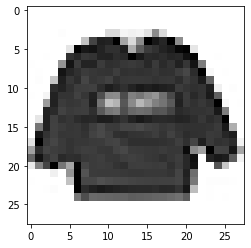

In [68]:
x, y = ds_train[0]


plt.imshow(x.reshape(28,28), cmap='Greys')
y

We then put these into a PyTorch DataLoaders to shuffle them and collate them into batches

In [69]:
batch_size = 4096

dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size)
dl_test = DataLoader(ds_test, batch_size)

In [70]:
x, y = next(iter(dl_train))
x, y

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 8,  ..., 8, 3, 9]))

We can then wrap these in a DataLoaders object

In [71]:
dls = DataLoaders(dl_train, dl_valid, dl_test)

In [72]:
dls.train, dls[0]

(<torch.utils.data.dataloader.DataLoader at 0x7f4c0e6e0450>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4c0e6e0450>)

### 4. Learner


Using the high level API did a lot of things:

```
learn = tabular_learner(dls, layers=[100], opt_func=SGD, metrics=accuracy, config=dict(use_bn=False, bn_cont=False))
```

1. build and initialise the model
2. set the metrics
3. set an appropriate loss function
4. register the optimizer

We'll do these parts manually and put them into a Learner.

#### 4.1 Model

Using PyTorch's Sequential we can easily rewrite the model manually

In [73]:
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

And run it over an example batch of data

In [74]:
x.shape

torch.Size([4096, 784])

We get 10 outputs for each item in the batch, as expected.

In [75]:
pred = model(x)
print(pred.shape)
pred

torch.Size([4096, 10])


tensor([[ 0.0838,  0.1000,  0.0104,  ..., -0.0319, -0.1107,  0.0448],
        [ 0.0488,  0.0577,  0.0980,  ...,  0.0814, -0.1584,  0.1305],
        [ 0.1289,  0.0631,  0.0885,  ...,  0.0194, -0.0895,  0.0239],
        ...,
        [ 0.1703,  0.0883,  0.0789,  ..., -0.0812, -0.1138,  0.1045],
        [ 0.0145,  0.0626,  0.1440,  ..., -0.0434, -0.1266,  0.2100],
        [ 0.0092,  0.2286,  0.2602,  ...,  0.0141, -0.0817,  0.0991]],
       grad_fn=<AddmmBackward0>)

#### 4.2 Metrics

We can calculate accuracy as the number of predictions that are the same as the labels.
Since we have 10 equally likely classes for our randomly initialised model it should be about 10%.

In [76]:
def accuracy(prob, actual):
    preds = prob.argmax(axis=-1)
    return sum(preds == actual.flatten()) / len(actual)

In [77]:
accuracy(pred, y)

tensor(0.0835)

### 4.3 Loss

The appropriate loss function for multiclass classification is CrossEntropy loss.

In [78]:
loss_function = nn.CrossEntropyLoss()

In [79]:
loss_function(pred, y)

tensor(2.3009, grad_fn=<NllLossBackward0>)

### Optimizer

PyTorch provides `torch.optim.SGD` optimizer but we can't use it directly with a Learner; from the [docs](https://docs.fast.ai/learner.html#Learner)

> The most important is opt_func. If you are not using a fastai optimizer, you will need to write a function that wraps your PyTorch optimizer in an OptimWrapper. See the optimizer module for more details. This is to ensure the library's schedulers/freeze API work with your code.

We'll use fastai's SGD instead for now.

### Putting it into Learner


In [80]:
learn = Learner(dls=dls, model=model, loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=[accuracy])

Note that this performs slightly worse than our original model which got to 82% accuracy and 0.5 validation loss in 5 epochs. It would be interesting to know what's changed!

With this kind of machine learning code a small change can make a big difference in how fast a model trains and how accurate it gets; this is why it's good to be able to dig into the detail!

In [81]:
learn.fit(5, lr=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.773703,1.286911,0.647599,00:00
1,1.426255,1.041697,0.638919,00:00
2,1.228973,0.891194,0.687113,00:00
3,1.102247,0.816285,0.696784,00:01
4,1.006129,0.768820,0.736877,00:00


# Training with base PyTorch

Now we're going to train the model again, but this time just using the basic utilities from Pytorch.
We'll also use no classes and keep everything as simple low level functions so we can see the underlying mechanics.

First we clear our namespace to prevent cheating.

In [82]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

## 1. Import

We'll import as few utilities as we can

In [83]:
import numpy as np
from torch import tensor, randn, arange, no_grad, stack

## 2. Load data

This time we'll load the data in using pure Numpy; because the data is just numbers it's easy to do this.

In [84]:
data = np.loadtxt('../input/fashionmnist/fashion-mnist_train.csv', skiprows=1, delimiter=',')

## 3. Dataloaders

In [85]:
valid_mask = np.random.choice([True, False], len(data), p=(0.2, 0.8))

In [86]:
X_train, y_train = tensor(data[~valid_mask, 1:].astype(np.float32) / 255.), tensor(data[~valid_mask,0].astype(np.int64))
X_valid, y_valid = tensor(data[ valid_mask, 1:].astype(np.float32) / 255.), tensor(data[ valid_mask,0].astype(np.int64))

### Learner

### 4.1 Model

Our model consists an *architecture* and *parameters*; we'll need a way to initialise those parameters.

In [87]:
def init_params(size, std=1.0): return (randn(size)*std).requires_grad_()    

Now, as before, we can set up 2 linear models with a ReLU between them.
In torch nn code this looks like:

```
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
```

The first linear layer consists of 784 * 100 weights plus 100 biases.
The ReLU layer has no parameters; it's just a nonlinear activation.
The final layer consists of 100 * 10 weights to 10 biases.

In [88]:
w1, b1 = init_params((784, 100)), init_params((100,))
w2, b2 = init_params((100, 10)), init_params((10,))

params = [w1, w2, b1, b2]

Our model then takes in the 784 pixels and performs:

* affine projection onto 100 dimensional space
* ReLU: Replace all the negative values by zero
* affine transformation onto 10 dimensional space

That looks like this:

In [89]:
def model(x):
    act1 = x@w1 + b1
    act2 = act1 * (act1 > 0)
    act3 = act2@w2 + b2
    return act3

This can take the predictor from our dataloader

In [90]:
x, y = X_train[:1024], y_train[:1024]

pred = model(x)

pred.shape

torch.Size([1024, 10])

### Metrics



In [91]:
def accuracy(pred, y): return sum(y.flatten() == pred.argmax(axis=1)) / len(y)

accuracy(pred, y)

tensor(0.0869)

In [92]:
accuracy(model(X_valid), y_valid)

tensor(0.0910)

### 3. Loss function

Our loss function is the *negative log likelihood*; the likelihood is how probable the data is given the model, that is we average the probabilities for the correct label, and then take the negative log.

The first step in calculating this is getting the model probabilities.
We normalise th predictions with a softmax; expoentiate to make positive, and then divide by the sum to normalise to 1.

Unfortunately if we do this naively we end up getting infinity because of the limits of floating point arithmetic.

In [93]:
pred.exp().sum(axis=1)

tensor([inf, inf, inf,  ..., inf, inf, inf], grad_fn=<SumBackward1>)

Instead we use the log probabilities, which have a better range in floating point space, and use the [log-sum-exp trick](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/) to make it stable (PyTorch has a [logsumexp function](https://pytorch.org/docs/stable/generated/torch.logsumexp.html), but it's easy to write.

In [94]:
def logsumexp(x):
    c = x.max(axis=1).values
    x_shift = x - c[:, None]
    return c + x_shift.exp().sum(axis=1).log()

Check they are the same

In [95]:
a = tensor([[1,2,3], [4,5,7]])

In [96]:
a.exp().sum(axis=1).log(), logsumexp(a)

(tensor([3.4076, 7.1698]), tensor([3.4076, 7.1698]))

We can then calculate the log probabilities using the softmax

In [97]:
logprob = a - logsumexp(a)[:, None]
logprob

tensor([[-2.4076, -1.4076, -0.4076],
        [-3.1698, -2.1698, -0.1698]])

And if we exponentiate them they sum to 1.

In [98]:
logprob.exp().sum(axis=1)

tensor([1., 1.])

In [99]:
def pred_to_logprob(pred):
    return pred - logsumexp(pred)[:, None]

In [100]:
pred_to_logprob(pred)[range(len(y)), y.long()]

tensor([-2.9484e+02, -4.0163e+02, -8.3874e+01,  ..., -1.9576e+02,
        -3.4655e+02, -4.0436e-03], grad_fn=<IndexBackward0>)

In [101]:
def loss_func(pred, y):
    logprob = pred_to_logprob(pred)
    
    true_prob = logprob[range(len(y)), y]
    
    return -true_prob.mean()

Our randomly initialised weights should on average give a ~1/10 probability to each class, and so the loss should be around -log(1/10) = 2.3.

In [102]:
loss = loss_func(pred, y)
loss

tensor(126.1162, grad_fn=<NegBackward0>)

### Optimizer

The SGD optimizer just moves each paramater a small step down the gradient to reduce the overall loss (and then we need to reset the gradients to zero).

We can easily run the whole training loop as follows (though note we get slightly worse accuracy than last time).

In [103]:
batch_size = 2048
lr = 0.2

for epoch in range(5):
    for _batch in range(len(X_train) // batch_size):
        # Data loader
        idx = np.random.choice(len(X_train), batch_size, replace=False)
        X, y = X_train[idx], y_train[idx]
        
        pred = model(X)
        loss = loss_func(pred, y)
        loss.backward()
        with no_grad():
            for p in params:
                p -= lr * p.grad
                p.grad.zero_()
                
            
    print(epoch, accuracy(model(X_valid), y_valid))

0 tensor(0.5943)
1 tensor(0.6033)
2 tensor(0.6119)
3 tensor(0.6306)
4 tensor(0.6387)


# What's the purpose of abstraction?

The high level tabular API is convenient for very quickly training a good model.
It has good defaults for things like the loss, model architecture and the optimiser, but it highly configurable if we want to change the defaults.
However this API is limited to the kinds of applications it's been built for; if we wanted a very different architecture or to work on a novel kind of input or output we can't use it.

The midlevel API exposes the Learner which is a *very* flexible training loop, and lets us use whatever kind of model, data, and optimiser we want.
This can be used for any number of tasks, but requires more work to implement the model, and choose the right hyperparameters.

Using the low level PyTorch API with minimal abstraction we can see how everything fits together.
There's no magic, and the training loop itself is rather simple.
However if we want to for example switch the optimiser, or the model, or the data type, it involves rewriting the training loop and it's a lot of work to maintain and debug.
The abstractions in the midlevel API often allow switching models, optimisers, data types, or metrics without changing anything else.

The next step would be to rebuild the abstractions to understand what they're actually doing.
Each time we went down a layer our model trained slower; with the right abstractions it's easy to focus on one piece at a time and work out *why* this happened (and maybe even discover a better way of training!)